In [1]:
# Standard library imports,
import time
import random
import string
import datetime

# Third-party imports,
import numpy as np
import matplotlib.pyplot as plt
from dataset import COVID_DATASET
import pandas as pd

# PyTorch imports,
import torch
from torchsummary import summary
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader

##  Model Architecture & Training Method

In [2]:
class ConfigDataset(Dataset):
    def __init__(self, path):
        """X is the training input while Y is the target output."""

        # Loading PyTorch dataset,
        dataset = torch.load(path)
        self.X = dataset.X
        self.Y = dataset.Y
        self.features = dataset.features
        self.classes = dataset.classes
        del dataset

    def __len__(self):
        """Returns the number of objects in the dataset."""
        return self.X.shape[0]

    def __getitem__(self, index):
        "Returns a tuple of training input and target output."
        return self.X[index], self.Y[index]

class NeuralNetwork(torch.nn.Module):
    """The neural network architecture."""

    def __init__(self):
        """Creating the layer stucture and activation functions of the neutral network."""
        super().__init__()

        # Layers,
        self.DenseLayer_INPUT = torch.nn.Linear(in_features = 62, out_features = 124)
        self.DenseLayer_HIDDEN_1 = torch.nn.Linear(in_features = 124, out_features = 124)
        self.DenseLayer_HIDDEN_2 = torch.nn.Linear(in_features = 124, out_features = 124)
        self.DenseLayer_HIDDEN_3 = torch.nn.Linear(in_features = 124, out_features = 24)
        self.DenseLayer_OUTPUT = torch.nn.Linear(in_features = 24, out_features = 2)

        # Activation functions,
        self.ReLU = torch.nn.ReLU()
        self.SoftMax = torch.nn.Softmax()

    def forward(self, X):
        """Defining the forward propagation."""

        X = self.DenseLayer_INPUT(X)
        X = self.ReLU(self.DenseLayer_HIDDEN_1(X))
        X = self.ReLU(self.DenseLayer_HIDDEN_2(X))
        X = self.ReLU(self.DenseLayer_HIDDEN_3(X))
        X = self.SoftMax(self.DenseLayer_OUTPUT(X))

        return X

def TrainModel(training_data, neural_network, model_name, n_epochs = 10, learning_rate = 0.01):

    print(model_name)
    summary(neural_network, (1, 62))
    print(" ")

    # Utilisation of CUDA if possible,
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f'CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}')
    else:
        device = torch.device("cpu")
        print('CUDA is not available. Using CPU.')

    neural_network.to(device)

    # Stochastic Gradient Descent (SGD) as optimiser,
    optimiser = SGD(neural_network.parameters(), lr = learning_rate)

    # Cross-Entropy loss function,
    loss_function = torch.nn.CrossEntropyLoss()

    losses = []
    epochs = np.arange(start = 1, stop = n_epochs, step = 1)

    for epoch in range(1, n_epochs + 1):
        epoch_loss = []
        stopwatch_start = time.time()
        for i, (X, Y) in enumerate(training_data):

            # Move data to selected device,
            X, Y = X.to(device), Y.to(device)

            # Back propagation,
            optimiser.zero_grad() 
            loss_value = loss_function(neural_network(X), Y) 
            epoch_loss.append(loss_value.item())
            loss_value.backward()
            optimiser.step()

        stopwatch_stop = time.time()
        epoch_time = round(stopwatch_stop - stopwatch_start, 2)
        epoch_avgloss = np.mean(epoch_loss)
        losses.append(epoch_avgloss)
        ETA = str(datetime.timedelta(seconds = (n_epochs - epoch)*epoch_time)).split(".")[0]
        update_string = f'[Completed Epoch: {epoch}/{n_epochs} - Time Taken: {epoch_time} secs - Loss: {epoch_avgloss:.5f} - ETA: {ETA} ]'
        print(update_string)

    torch.save(neural_network.state_dict(), f'{model_name}.pth')
    return np.array(epochs), np.array(losses)

def AssessModel(test_data, neural_network):

    X_test = test_data[:][0]
    Y_test = test_data[:][1]
    Yhat_test = neural_network(X_test)

    correct_counter = 0
    incorrect_counter = 0
    for Y, Yhat in zip(Y_test, Yhat_test):
        if Yhat.argmax() == Y.argmax():
            correct_counter += 1
        else:
            incorrect_counter += 1

    accuracy = correct_counter/(correct_counter + incorrect_counter)

    return accuracy

## Model Training Algorithm

In [3]:
# Hyperparameters,
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01

if __name__ == "__main__":

    ID = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(5))
    model_name = "Model-" + ID

    # Creating and training neural network,
    training_dataset = ConfigDataset("training.pt")
    training_dataset_loaded = DataLoader(training_dataset, BATCH_SIZE)

    # Print example,
    train_features, train_labels = next(iter(training_dataset_loaded))
    print(f"Input Batch Shape: {train_features.size()}")
    print(f"Target Batch Shape: {train_labels.size()}")
    print(f"Number of Training Examples: {training_dataset.__len__()}")
    random_index = random.randint(0, BATCH_SIZE - 1)
    label = train_labels[random_index]
    print(f"Example Label: {label}")

    # Creating and training neural network,
    neural_network = NeuralNetwork()
    epoch_array, loss_array = TrainModel(training_dataset_loaded, neural_network, model_name, EPOCHS, LEARNING_RATE)

    # Testing neural network,
    test_dataset = ConfigDataset("test.pt")
    print("Accuracy: " + str(AssessModel(test_dataset, neural_network)))

Input Batch Shape: torch.Size([32, 62])
Target Batch Shape: torch.Size([32, 2])
Number of Training Examples: 119124
Example Label: tensor([0., 1.])
Model-SIM3T
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 124]              7,812
├─Linear: 1-2                            [-1, 1, 124]              15,500
├─ReLU: 1-3                              [-1, 1, 124]              --
├─Linear: 1-4                            [-1, 1, 124]              15,500
├─ReLU: 1-5                              [-1, 1, 124]              --
├─Linear: 1-6                            [-1, 1, 24]               3,000
├─ReLU: 1-7                              [-1, 1, 24]               --
├─Linear: 1-8                            [-1, 1, 2]                50
├─Softmax: 1-9                           [-1, 1, 2]                --
Total params: 41,862
Trainable params: 41,862
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
For

C:\Users\Prithvi\AppData\Local\Temp\ipykernel_9108\2573971766.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.SoftMax(self.DenseLayer_OUTPUT(X))


[Completed Epoch: 1/50 - Time Taken: 4.8 secs - Loss: 0.52285 - ETA: 0:03:55 ]
[Completed Epoch: 2/50 - Time Taken: 5.16 secs - Loss: 0.40292 - ETA: 0:04:07 ]
[Completed Epoch: 3/50 - Time Taken: 5.44 secs - Loss: 0.40126 - ETA: 0:04:15 ]
[Completed Epoch: 4/50 - Time Taken: 5.58 secs - Loss: 0.40038 - ETA: 0:04:16 ]
[Completed Epoch: 5/50 - Time Taken: 4.79 secs - Loss: 0.39981 - ETA: 0:03:35 ]
[Completed Epoch: 6/50 - Time Taken: 4.85 secs - Loss: 0.39943 - ETA: 0:03:33 ]
[Completed Epoch: 7/50 - Time Taken: 4.81 secs - Loss: 0.39914 - ETA: 0:03:26 ]
[Completed Epoch: 8/50 - Time Taken: 4.89 secs - Loss: 0.39888 - ETA: 0:03:25 ]
[Completed Epoch: 9/50 - Time Taken: 4.81 secs - Loss: 0.39863 - ETA: 0:03:17 ]
[Completed Epoch: 10/50 - Time Taken: 4.89 secs - Loss: 0.39840 - ETA: 0:03:15 ]
[Completed Epoch: 11/50 - Time Taken: 4.86 secs - Loss: 0.39822 - ETA: 0:03:09 ]
[Completed Epoch: 12/50 - Time Taken: 4.89 secs - Loss: 0.39808 - ETA: 0:03:05 ]
[Completed Epoch: 13/50 - Time Taken: 

## Model Loader

In [4]:
MODEL_FILE = "Model-SIM3T.pth"

# Loading model,
model = NeuralNetwork()
model.load_state_dict(torch.load(MODEL_FILE))
model.eval()

NeuralNetwork(
  (DenseLayer_INPUT): Linear(in_features=62, out_features=124, bias=True)
  (DenseLayer_HIDDEN_1): Linear(in_features=124, out_features=124, bias=True)
  (DenseLayer_HIDDEN_2): Linear(in_features=124, out_features=124, bias=True)
  (DenseLayer_HIDDEN_3): Linear(in_features=124, out_features=24, bias=True)
  (DenseLayer_OUTPUT): Linear(in_features=24, out_features=2, bias=True)
  (ReLU): ReLU()
  (SoftMax): Softmax(dim=None)
)

# Feature Importance

In [5]:
def feature_importance(model, X_sample, plot = True):

    # Forward pass,
    X_sample.requires_grad = True
    Y_pred = model(X_sample)

    # Computing gradients with respect to the loss function via back propagation,
    loss = Y_pred.mean()
    loss.backward()

    # Calculate feature importance as the absolute mean of gradients found,
    feature_importance = torch.abs(X_sample.grad).mean(dim = 0).numpy()

    # Extracting feature names,
    feature_names = []
    for key in test_dataset.features:
        for unique_label in test_dataset.features[key]:
            feature_names.append(key + "_" +  unique_label)

    # Extracting general features and their calculating importance by summing contributions,
    general_features = {}
    for feature_importance, feature_name in zip(feature_importance, feature_names):
        general_feature = feature_name.rsplit("_", 1)[0]

        try:
            general_features[general_feature].append(feature_importance)
        except:
            general_features[general_feature] = []
            general_features[general_feature].append(feature_importance)

    for general_feature in general_features:
        general_features[general_feature] = np.sum(general_features[general_feature])

    # Creating and sorting dataframe,
    general_features = pd.DataFrame(data = {"General Feature": list(general_features.keys()), 
                                            "Importance": list(general_features.values())})
    general_features = general_features.sort_values(by = "Importance", ascending = False)

    # Plotting,
    if plot == True:
        general_features = general_features["General Feature"].to_numpy(), general_features["Importance"].to_numpy()
        plt.bar(general_features[0], general_features[1])
        plt.title("Feature Importance")
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.xticks(rotation = 90)
        plt.plot()

    return general_features

C:\Users\Prithvi\AppData\Local\Temp\ipykernel_9108\2573971766.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.SoftMax(self.DenseLayer_OUTPUT(X))


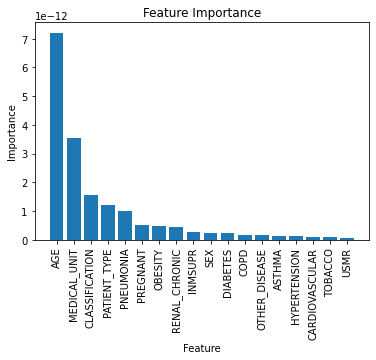

In [6]:
# Determining feature importance,
test_dataset = ConfigDataset("test.pt")
X_sample = test_dataset[:][0]
df_features = feature_importance(model, X_sample)